## 參考技術
#### Tracking:
1. https://github.com/LeonLok/Deep-SORT-YOLOv4
2. https://github.com/theAIGuysCode/yolov4-deepsort

#### Image Segmentation
1. https://github.com/tensorflow/models/tree/master/research/deeplab

#### Style Classification
1. https://www.sheerdevelopment.com/posts/colour-detection
2. https://openaccess.thecvf.com/content_ICCVW_2019/papers/CVFAD/Sidnev_DeepMark_One-Shot_Clothing_Detection_ICCVW_2019_paper.pdf
3. https://github.com/switchablenorms/DeepFashion2

# Running the Tracker with YOLOv4

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



In [2]:
!python save_model.py --model yolov4




2020-10-20 20:56:19.405480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-10-20 20:56:19.420987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9c09e8e8d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-20 20:56:19.421004: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________

batch_normalization_28 (BatchNo (None, 52, 52, 128)  512         conv2d_28[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Softplus_28 (Tensor [(None, 52, 52, 128) 0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
tf_op_layer_Tanh_28 (TensorFlow [(None, 52, 52, 128) 0           tf_op_layer_Softplus_28[0][0]    
__________________________________________________________________________________________________
tf_op_layer_Mul_28 (TensorFlowO [(None, 52, 52, 128) 0           batch_normalization_28[0][0]     
                                                                 tf_op_layer_Tanh_28[0][0]        
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 52, 52, 128)  147456      tf_op_layer_Mul_28[0][0]         
__________

Total params: 64,429,405
Trainable params: 64,363,101
Non-trainable params: 66,304
__________________________________________________________________________________________________
2020-10-20 20:56:39.313434: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: ./checkpoints/yolov4-416/assets
I1020 20:57:10.197865 4576832960 builder_impl.py:775] Assets written to: ./checkpoints/yolov4-416/assets


In [3]:
!python object_tracker.py --video ./data/video/ocean_city-fps30.mp4 --output ./outputs/ocean_city_output.avi --model yolov4 --dont_show True --info_output ./outputs/ocean_city_info_output.csv




Frame #:  1
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 0.77
Frame #:  2
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 1.24
Frame #:  3
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.57
Frame #:  4
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.67
Frame #:  5
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.65
Frame #:  6
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.65
Frame #:  7
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.75
Frame #:  8
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.64
Frame #:  9
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.60
Frame #:  10
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.63
Frame #:  11
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.67
Frame #:  12
output_fps #:  30
appear_sec #:  1
appear_time #:  0:01
FPS: 2.60
Frame #:  13
output_fps #:  30
appear_sec #:  1
appear_time #

FPS: 2.67
Frame #:  105
output_fps #:  30
appear_sec #:  4
appear_time #:  0:04
FPS: 2.77
Frame #:  106
output_fps #:  30
appear_sec #:  4
appear_time #:  0:04
FPS: 2.68
Frame #:  107
output_fps #:  30
appear_sec #:  4
appear_time #:  0:04
FPS: 2.71
Frame #:  108
output_fps #:  30
appear_sec #:  4
appear_time #:  0:04
^C


# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

In [5]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from numpy import savetxt

In [6]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map
  
  def no_resize_run(self, image):
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [image]})
    seg_map = batch_seg_map[0]
    return seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [7]:
MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.compat.v1.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [151]:
def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    #print(BytesIO(jpeg_str))
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  print(type(original_im))
  resized_im, seg_map = MODEL.run(original_im)
  #savetxt('seg_map_data.csv', seg_map, delimiter=',')
  vis_segmentation(resized_im, seg_map)

running deeplab on image https://spectrum.ieee.org/image/MzY3OTc2NQ.jpeg...
<class 'PIL.JpegImagePlugin.JpegImageFile'>


/Users/karlque/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


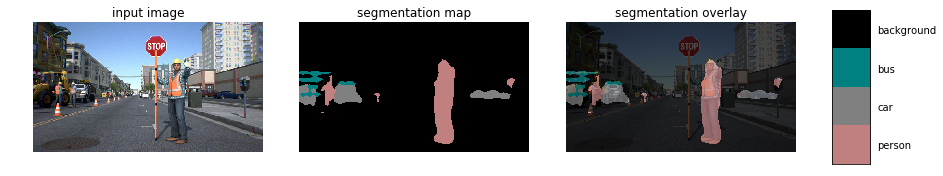

In [43]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://spectrum.ieee.org/image/MzY3OTc2NQ.jpeg'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

/Users/karlque/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


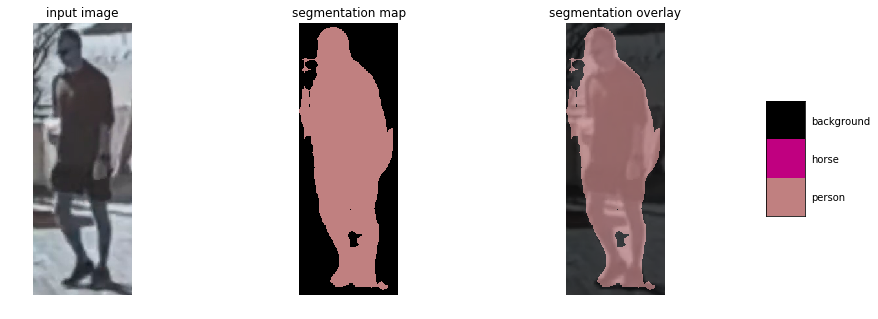

In [66]:
# model mobilenetv2_coco_voctrainaug
seg_map = MODEL.no_resize_run(capture_image)
vis_segmentation(capture_image, seg_map)

/Users/karlque/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


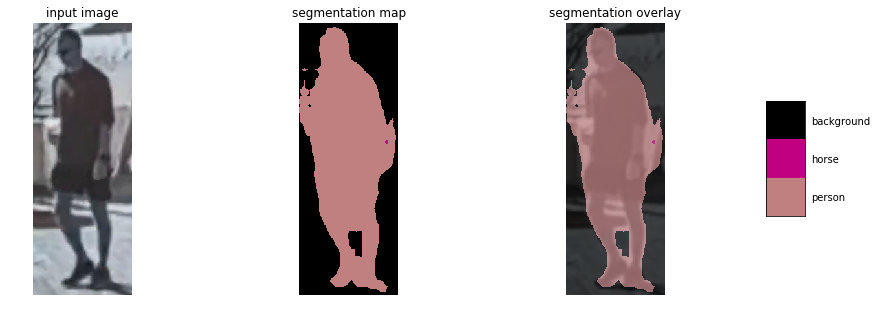

In [68]:
# model mobilenetv2_coco_voctrainval
seg_map = MODEL.no_resize_run(capture_image)
vis_segmentation(capture_image, seg_map)

/Users/karlque/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


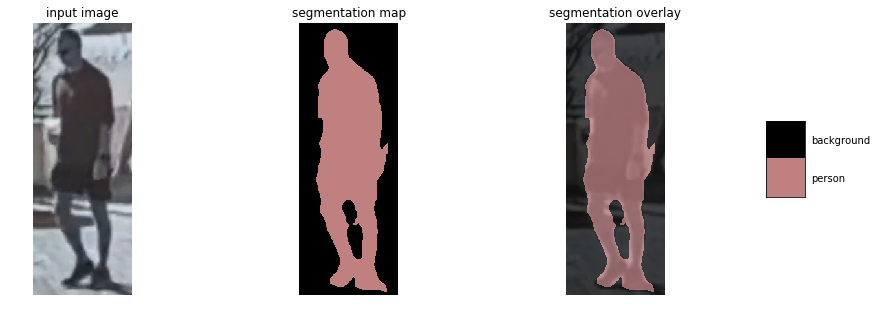

In [138]:
# model xception_coco_voctrainaug
seg_map = MODEL.no_resize_run(capture_image)
vis_segmentation(capture_image, seg_map)

/Users/karlque/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


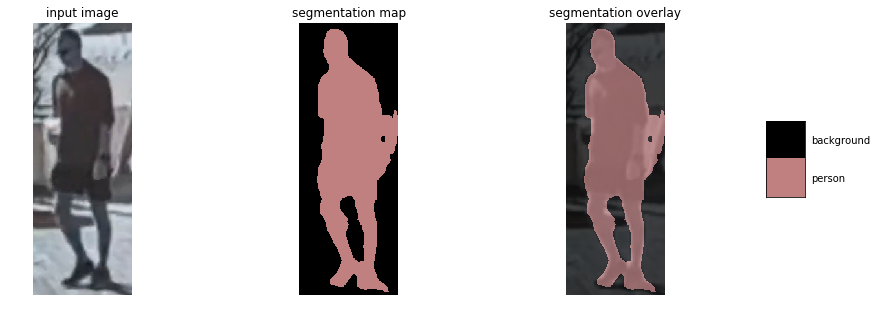

In [72]:
# model xception_coco_voctrainval
seg_map = MODEL.no_resize_run(capture_image)
vis_segmentation(capture_image, seg_map)

(422, 153, 3)


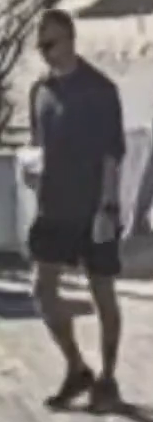

(422, 153, 3)


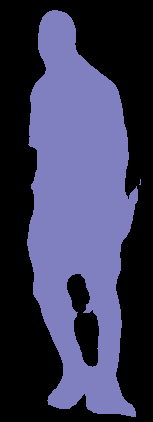

In [139]:
backend_image = cv2.imread(backend_image_path)
#cv2_imshow(backend_image)
print(capture_image.shape)
cv2_imshow(capture_image)
seg_image = label_to_color_image(seg_map).astype(np.uint8)
print(seg_image.shape)
cv2_imshow(seg_image)

#for idx, x in np.ndenumerate(seg_image):
#  print(idx, x)

#seg_image[seg_image > 0] = 1
#new_capture_image = capture_image * seg_image
#cv2_imshow(new_capture_image)


In [141]:
seg_map.shape

(422, 153)

In [14]:
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
from PIL import Image

input_video = './data/video/ocean_city-fps30.mp4'
output_video = './outputs/full_25_super_ocean_city-fps30.avi'
deepsort_result_csv = './outputs/ocean_city-fps30.csv'
backend_image_path = './outputs/IMG_4587.JPG'

track_info = pd.read_csv(deepsort_result_csv, index_col='Unnamed: 0')

try:
    vid = cv2.VideoCapture(int(input_video))
except:
    vid = cv2.VideoCapture(input_video)

out = None
input_max = 25

print('seq ====================')
obj_data = track_info[['appear_time','frame','tracker_id','bbox_xmin','bbox_ymin','bbox_xmax','bbox_ymax']]
tracker_id_list = obj_data['tracker_id'].unique()
print(tracker_id_list)
print(tracker_id_list[::5])
print(tracker_id_list[1::5])
print(tracker_id_list[2::5])
print(tracker_id_list[3::5])
print(tracker_id_list[4::5])

groups = []
for group_index in range(input_max):
  group_ids = tracker_id_list[group_index::input_max]
  group_obj = obj_data[obj_data['tracker_id'].isin(group_ids)].sort_values(['tracker_id','frame'])
  groups.append(group_obj)

print('seq ====================')

groups_frames = []
for group_info in groups:
    groups_frames.append(group_info.shape[0])
    
max_frames = max(groups_frames)

# by default VideoCapture returns float instead of int
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_fps = int(vid.get(cv2.CAP_PROP_FPS))
codec = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video, codec, output_fps, (width, height))

backend_index = 0
for backend_index in range(max_frames):
  backend = backend_image = cv2.imread(backend_image_path)
  print(f"creating... frame #" + str(backend_index))

  for group_obj in groups:
    if group_obj.shape[0] < backend_index:
      continue
    
    obj = group_obj.iloc[backend_index]

    #print('==============')
    
    #print(obj)
    frame_index = obj['frame'] - 1
    bbox_xmin = obj['bbox_xmin']
    bbox_ymin = obj['bbox_ymin']
    bbox_xmax = obj['bbox_xmax']
    bbox_ymax = obj['bbox_ymax']
    #print('=================')

    vid.set(cv2.CAP_PROP_POS_FRAMES,frame_index)
    ret, frame = vid.read()

    if backend is None:
      backend = frame.copy()
      backend.fill(200)
    
    capture_image = frame[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
    #seg_map = MODEL.no_resize_run(capture_image)
    mask_img = capture_image.copy()
#     seg_map = MODEL.no_resize_run(capture_image)
    y_len = mask_img.shape[0]
    x_len = mask_img.shape[1]
    center = (int(x_len/2), int(y_len/2))
    axes = (int(x_len/2) + 10, int(y_len/2) +10)
    cv2.ellipse(mask_img, center, axes, 0, 0, 360, 0, -1)
    
    # mask capture
    new_image = capture_image.copy()
    for idx, x in np.ndenumerate(mask_img):
        if x == 0:
            backend[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax][idx] = capture_image[idx]
    
    # mask capture
    #for idx, x in np.ndenumerate(seg_map):
    #    if x == 15:
    #        backend[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax][idx] = capture_image[idx]
    
    #backend[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax] = capture_image
    cv2.putText(backend, 'id:'+str(obj.tracker_id) + " " + str(obj.appear_time),(bbox_xmin, int(bbox_ymin-10)),0, 0.75, (0,0,0),2)

  #result = cv2.cvtColor(backend, cv2.COLOR_BGR2RGB)
  #cv2_imshow(backend)
  #result = cv2.resize(result,(width, height))
  out.write(backend)
    
    #ROI = frame[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
    #backend[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax] = frame[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax]
    #cv2.rectangle(frame,(bbox_xmin,bbox_ymin),(bbox_xmax,bbox_ymax),(0,255,0),2)
    #print(ROI)
    #cv2_imshow(ROI)
    #cv2_imshow(frame[bbox_ymin:bbox_ymax, bbox_xmin:bbox_xmax])
    #if cv2.waitKey(1) & 0xFF == ord('q'): break
  #backend_index += 1
cv2.destroyAllWindows()




seq ====================
[  1   2   3   4   5   6   7   8  10  13  15  18  20  23  24  25  28  29
  32  34  35  36  39  43  46  48  49  51  52  53  55  57  58  59  60  61
  63  65  66  68  72  74  75  77  80  81  83  84  85  93  95  96  99 100
 101 103 109 110 112 114 115 116 118 119 121 122 125 127 128 133 134 135
 137 138 140 141 142 143 145 146 149 151 153 159 161 162 163 164 165 166
 167 168 169 172 173 174 176 177 185 186 187 189 190 191 192 195 196 197
 202 203 209 212 215 216 218 219 220 222 223 224 226 227 229 230 232 233
 234 235 237 238 239 240 244 245 248 250 251 253 254 257 259 260 264 265
 266 271 273 276 277 279 280 281 282 283 284 285 288 289 290 291 292 293
 294 297 299 302 303 308 310 312 313 315 316 322 323 324 327 328 330 334
 335 338 342 343 344 345 347 348 350 351 353 355 359 361 362 363 365 368
 370 371 376 377 381 384 385 386 387 388 391 393 395 397 399 400 403 409
 410 412 413 416 420 421 422 425 427 428 430 433 435 439 442 443 445 446
 447 448 449 450 451 452 4

creating... frame #273
creating... frame #274
creating... frame #275
creating... frame #276
creating... frame #277
creating... frame #278
creating... frame #279
creating... frame #280
creating... frame #281
creating... frame #282
creating... frame #283
creating... frame #284
creating... frame #285
creating... frame #286
creating... frame #287
creating... frame #288
creating... frame #289
creating... frame #290
creating... frame #291
creating... frame #292
creating... frame #293
creating... frame #294
creating... frame #295
creating... frame #296
creating... frame #297
creating... frame #298
creating... frame #299
creating... frame #300
creating... frame #301
creating... frame #302
creating... frame #303
creating... frame #304
creating... frame #305
creating... frame #306
creating... frame #307
creating... frame #308
creating... frame #309
creating... frame #310
creating... frame #311
creating... frame #312
creating... frame #313
creating... frame #314
creating... frame #315
creating...

creating... frame #630
creating... frame #631
creating... frame #632
creating... frame #633
creating... frame #634
creating... frame #635
creating... frame #636
creating... frame #637
creating... frame #638
creating... frame #639
creating... frame #640
creating... frame #641
creating... frame #642
creating... frame #643
creating... frame #644
creating... frame #645
creating... frame #646
creating... frame #647
creating... frame #648
creating... frame #649
creating... frame #650
creating... frame #651
creating... frame #652
creating... frame #653
creating... frame #654
creating... frame #655
creating... frame #656
creating... frame #657
creating... frame #658
creating... frame #659
creating... frame #660
creating... frame #661
creating... frame #662
creating... frame #663
creating... frame #664
creating... frame #665
creating... frame #666
creating... frame #667
creating... frame #668
creating... frame #669
creating... frame #670
creating... frame #671
creating... frame #672
creating...

creating... frame #987
creating... frame #988
creating... frame #989
creating... frame #990
creating... frame #991
creating... frame #992
creating... frame #993
creating... frame #994
creating... frame #995
creating... frame #996
creating... frame #997
creating... frame #998
creating... frame #999
creating... frame #1000
creating... frame #1001
creating... frame #1002
creating... frame #1003
creating... frame #1004
creating... frame #1005
creating... frame #1006
creating... frame #1007
creating... frame #1008
creating... frame #1009
creating... frame #1010
creating... frame #1011
creating... frame #1012
creating... frame #1013
creating... frame #1014
creating... frame #1015
creating... frame #1016
creating... frame #1017
creating... frame #1018
creating... frame #1019
creating... frame #1020
creating... frame #1021
creating... frame #1022
creating... frame #1023
creating... frame #1024
creating... frame #1025
creating... frame #1026
creating... frame #1027
creating... frame #1028
creat

creating... frame #1329
creating... frame #1330
creating... frame #1331
creating... frame #1332
creating... frame #1333
creating... frame #1334
creating... frame #1335
creating... frame #1336
creating... frame #1337
creating... frame #1338
creating... frame #1339
creating... frame #1340
creating... frame #1341
creating... frame #1342
creating... frame #1343
creating... frame #1344
creating... frame #1345
creating... frame #1346
creating... frame #1347
creating... frame #1348
creating... frame #1349
creating... frame #1350
creating... frame #1351
creating... frame #1352
creating... frame #1353
creating... frame #1354
creating... frame #1355
creating... frame #1356
creating... frame #1357
creating... frame #1358
creating... frame #1359
creating... frame #1360
creating... frame #1361
creating... frame #1362
creating... frame #1363
creating... frame #1364
creating... frame #1365
creating... frame #1366
creating... frame #1367
creating... frame #1368
creating... frame #1369
creating... fram

IndexError: single positional indexer is out-of-bounds

In [11]:
max_frames

8741